# Predicting AirBnb prices with machine learning algorithm

## Overview
This research is conducted on datasets obtained by Gyódi, Kristóf and Nawaro, Łukasz.

This project focuses on predicting Airbnb prices in Europe using machine learning algorithm. Accurate price prediction is crucial for hosts to set competitive rates and maximize revenue, while travelers benefit from reliable estimates for budget planning. The Random Forest Regressor algorithm, known for its ensemble of decision trees, offers a robust solution. By analyzing historical data and considering factors like location, property type, and day of the week, the model can provide valuable insights into the factors influencing Airbnb prices. The project aims to benefit hosts and travelers in the European Airbnb market with accurate price predictions and informed decision-making.

<b>The columns in the datasets:

* realSum: the full price of accommodation for two people and two nights in EUR
* room_type: the type of the accommodation 
* room_shared: dummy variable for shared rooms
* room_private: dummy variable for private rooms
* person_capacity: the maximum number of guests 
* host_is_superhost: dummy variable for superhost status
* multi: dummy variable if the listing belongs to hosts with 2-4 offers
* biz: dummy variable if the listing belongs to hosts with more than 4 offers
* cleanliness_rating: cleanliness rating
* guest_satisfaction_overall: overall rating of the listing
* bedrooms: number of bedrooms (0 for studios)
* dist: distance from city centre in km
* metro_dist: distance from nearest metro station in km
* attr_index: attraction index of the listing location
* attr_index_norm: normalised attraction index (0-100)
* rest_index: restaurant index of the listing location
* attr_index_norm: normalised restaurant index (0-100)
* lng: longitude of the listing location
* lat: latitude of the listing location

## Data inspection
There are 20 csv files in this dataset. It is better to merge them in a single dataset to perform further research.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Assigning csv files path to a variable and initiating dataframes dictionary
folder_path = 'archive'
dataframes = {}

In [3]:
# Iterating through every csv file and storing it in a dictionary with file name as a key
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dataframe_name = os.path.splitext(file_name)[0]
        dataframes[dataframe_name] = df

In [4]:
# Creating a new column for each DataFrame with it's name
for key in dataframes.keys():
    dataframes[key]['geo'] = key

In [5]:
# Concatenating dataframes
df = pd.concat(dataframes.values()).reset_index()

In [6]:
# Splitting file name into two columns: geography and time of the week
df['week'] = df.geo.apply(lambda x: x.split('_')[1])
df['geo'] = df.geo.apply(lambda x: x.split('_')[0])

# Dropping columns
df = df.drop(['index', 'Unnamed: 0'], axis=1)

***
Now that we have a single dataframe, we can start data inspection

In [7]:
# Inspecting data
display(df.head())
display(df.info())

realSum     room_type  room_shared  room_private  person_capacity  \
0  194.033698  Private room        False          True              2.0   
1  344.245776  Private room        False          True              4.0   
2  264.101422  Private room        False          True              2.0   
3  433.529398  Private room        False          True              4.0   
4  485.552926  Private room        False          True              2.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0              False      1    0                10.0   
1              False      0    0                 8.0   
2              False      0    1                 9.0   
3              False      0    1                 9.0   
4               True      0    0                10.0   

   guest_satisfaction_overall  ...      dist  metro_dist  attr_index  \
0                        93.0  ...  5.022964    2.539380   78.690379   
1                        85.0  ...  0.488389    0.239404  631.176378   
2                        87.0  ...  5.748312    3.651621   75.275877   
3                        90.0  ...  0.384862    0.439876  493.272534   
4                        98.0  ...  0.544738    0.318693  552.830324   

   attr_index_norm  rest_index  rest_index_norm      lng       lat        geo  \
0         4.166708   98.253896         6.846473  4.90569  52.41772  amsterdam   
1        33.421209  837.280757        58.342928  4.90005  52.37432  amsterdam   
2         3.985908   95.386955         6.646700  4.97512  52.36103  amsterdam   
3        26.119108  875.033098        60.973565  4.89417  52.37663  amsterdam   
4        29.272733  815.305740        56.811677  4.90051  52.37508  amsterdam   

       week  
0  weekdays  
1  weekdays  
2  weekdays  
3  weekdays  
4  weekdays  

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  bool   
 3   room_private                51707 non-null  bool   
 4   person_capacity             51707 non-null  float64
 5   host_is_superhost           51707 non-null  bool   
 6   multi                       51707 non-null  int64  
 7   biz                         51707 non-null  int64  
 8   cleanliness_rating          51707 non-null  float64
 9   guest_satisfaction_overall  51707 non-null  float64
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  attr_index                  517

None

We have 5107 observations with no missing values. Every column data type is corresponding to its feature.

In [8]:
# Check for number of values in categorical columns
display(df.room_type.value_counts(normalize=True))
display(df.geo.value_counts(normalize=True))
display(df.week.value_counts(normalize=True))

Entire home/apt    0.631404
Private room       0.361518
Shared room        0.007078
Name: room_type, dtype: float64

london       0.193262
rome         0.174580
paris        0.129344
lisbon       0.111455
athens       0.102114
budapest     0.077784
vienna       0.068405
barcelona    0.054789
berlin       0.048040
amsterdam    0.040227
Name: geo, dtype: float64

weekends    0.506837
weekdays    0.493163
Name: week, dtype: float64

Categorical data ispection shows that shared rooms take less than 1 percent of the database. It would be reasonable to drop these rows since this few observations may be biased. There are also boolean columns that duplicate information in 'room_type' column. I will delete them too.
Geography and time of the week are distributed evenly enough.

In [9]:
# Deleting 'shared room' rows
df.drop(labels=df[df.room_type == 'Shared room'].index, inplace=True)

# Deleting 'room_shared' and 'room_private' columns
df.drop(columns=['room_shared', 'room_private'], inplace=True)
df = df.reset_index(drop=True)
display(df)

realSum        room_type  person_capacity  host_is_superhost  \
0       194.033698     Private room              2.0              False   
1       344.245776     Private room              4.0              False   
2       264.101422     Private room              2.0              False   
3       433.529398     Private room              4.0              False   
4       485.552926     Private room              2.0               True   
...            ...              ...              ...                ...   
51336  1035.066676     Private room              2.0              False   
51337   181.095510     Private room              2.0              False   
51338   420.517886  Entire home/apt              2.0              False   
51339   217.314612     Private room              2.0              False   
51340   489.193067  Entire home/apt              2.0              False   

       multi  biz  cleanliness_rating  guest_satisfaction_overall  bedrooms  \
0          1    0                10.0                        93.0         1   
1          0    0                 8.0                        85.0         1   
2          0    1                 9.0                        87.0         1   
3          0    1                 9.0                        90.0         2   
4          0    0                10.0                        98.0         1   
...      ...  ...                 ...                         ...       ...   
51336      0    1                10.0                       100.0         0   
51337      1    0                10.0                       100.0         1   
51338      0    0                10.0                        98.0         1   
51339      0    0                10.0                        94.0         1   
51340      0    0                 9.0                        92.0         1   

           dist  metro_dist  attr_index  attr_index_norm  rest_index  \
0      5.022964    2.539380   78.690379         4.166708   98.253896   
1      0.488389    0.239404  631.176378        33.421209  837.280757   
2      5.748312    3.651621   75.275877         3.985908   95.386955   
3      0.384862    0.439876  493.272534        26.119108  875.033098   
4      0.544738    0.318693  552.830324        29.272733  815.305740   
...         ...         ...         ...              ...         ...   
51336  5.155373    0.883829  271.191201        18.851558  528.042180   
51337  5.072177    0.344055  268.165870        18.641255  554.906232   
51338  6.709982    0.926188  181.892001        12.644022  395.397885   
51339  6.736940    0.353634  184.278328        12.809905  471.029678   
51340  4.174953    0.610443  434.954210        30.235363  697.673227   

       rest_index_norm      lng       lat        geo      week  
0             6.846473  4.90569  52.41772  amsterdam  weekdays  
1            58.342928  4.90005  52.37432  amsterdam  weekdays  
2             6.646700  4.97512  52.36103  amsterdam  weekdays  
3            60.973565  4.89417  52.37663  amsterdam  weekdays  
4            56.811677  4.90051  52.37508  amsterdam  weekdays  
...                ...      ...       ...        ...       ...  
51336         9.451035 -0.05357  51.51255     london  weekends  
51337         9.931855 -0.05620  51.51823     london  weekends  
51338         7.076933 -0.22172  51.52180     london  weekends  
51339         8.430610 -0.22286  51.49715     london  weekends  
51340        12.487135 -0.06739  51.50889     london  weekends  

[51341 rows x 19 columns]

It will be reasonable to round the 'realSum' values to zero decimals and distance columns to two decimals. Data inspection showed that latitude and longitude were used by the authors to find attraction index and restaurant index so we can get rid of them.

In [10]:
# Rounding decimal features
df['realSum'] = df['realSum'].apply(lambda x: round(x, 0))
df['dist'] = df['dist'].apply(lambda x: round(x, 2))
df['metro_dist'] = df['metro_dist'].apply(lambda x: round(x, 2))

# Dropping longitude and latitude
df.drop(columns=['lng', 'lat'], inplace=True)
df = df.reset_index(drop=True)

Even though we have checked that there are no missing values, there is still a chance that missing data could be inputed in some other way. I will look into the unique values to be sure.

In [11]:
# Removing rows and columns display limit
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Printing unique values for every column
for i in df.columns:
    display(i)
    display(df[i].value_counts())

'realSum'

162.0      671
139.0      549
116.0      464
127.0      464
104.0      428
151.0      406
168.0      402
174.0      394
173.0      374
133.0      350
196.0      328
220.0      323
150.0      323
197.0      317
208.0      313
155.0      308
232.0      308
159.0      304
184.0      297
180.0      293
194.0      291
185.0      280
129.0      272
243.0      271
145.0      264
128.0      263
122.0      263
278.0      261
182.0      255
231.0      253
142.0      252
191.0      246
255.0      243
209.0      236
219.0      233
206.0      231
179.0      230
137.0      229
93.0       227
136.0      224
138.0      223
290.0      214
115.0      214
123.0      211
171.0      208
135.0      206
203.0      205
147.0      204
183.0      202
125.0      197
101.0      195
124.0      193
148.0      192
113.0      190
160.0      189
205.0      189
202.0      188
110.0      185
176.0      184
157.0      183
195.0      183
336.0      182
81.0       182
144.0      181
263.0      180
186.0      179
175.0     

'room_type'

Entire home/apt    32648
Private room       18693
Name: room_type, dtype: int64

'person_capacity'

2.0    24193
4.0    13909
3.0     6136
6.0     4180
5.0     2923
Name: person_capacity, dtype: int64

'host_is_superhost'

False    38150
True     13191
Name: host_is_superhost, dtype: int64

'multi'

0    36351
1    14990
Name: multi, dtype: int64

'biz'

0    33453
1    17888
Name: biz, dtype: int64

'cleanliness_rating'

10.0    29928
9.0     15321
8.0      4295
7.0       933
6.0       490
2.0       141
4.0       137
5.0        86
3.0        10
Name: cleanliness_rating, dtype: int64

'guest_satisfaction_overall'

100.0    10624
98.0      3874
97.0      3617
96.0      3514
93.0      3304
95.0      3276
94.0      2598
90.0      2577
99.0      2333
80.0      2030
92.0      2002
91.0      1773
88.0      1358
89.0      1304
87.0      1249
85.0       771
86.0       764
84.0       658
83.0       581
60.0       469
82.0       350
70.0       265
81.0       208
73.0       186
78.0       175
75.0       172
76.0       171
77.0       163
79.0       161
20.0       153
40.0       119
67.0        97
74.0        81
72.0        71
71.0        51
50.0        44
68.0        33
65.0        32
69.0        32
63.0        21
47.0        16
53.0        14
64.0        13
30.0         8
66.0         6
56.0         5
57.0         5
55.0         4
62.0         4
44.0         2
46.0         1
54.0         1
61.0         1
Name: guest_satisfaction_overall, dtype: int64

'bedrooms'

1     35967
2      9290
0      4485
3      1477
4        96
5        10
9        10
6         2
8         2
10        2
Name: bedrooms, dtype: int64

'dist'

1.12     186
1.43     169
0.94     163
0.88     153
0.95     152
1.19     152
1.85     150
1.46     149
2.68     144
1.30     141
2.20     140
1.17     139
1.09     139
1.01     139
1.73     138
3.08     138
1.97     137
1.90     137
1.11     137
1.07     136
1.63     135
1.06     134
1.29     134
1.34     133
1.22     132
1.35     132
1.08     132
1.98     131
2.09     131
1.27     130
2.29     129
2.11     129
2.56     129
0.86     128
1.14     128
2.18     128
1.99     127
1.50     127
1.16     127
1.96     127
1.24     126
2.35     125
2.24     125
1.25     125
1.10     125
1.33     125
2.28     124
1.62     124
1.86     123
0.93     123
1.38     123
1.55     123
1.23     123
2.32     123
1.42     123
1.79     122
1.00     122
2.43     122
1.89     121
2.51     121
2.16     121
1.68     121
0.97     120
2.57     120
1.58     120
2.02     120
1.66     119
1.31     119
1.78     119
1.70     119
2.45     118
2.30     118
1.87     118
2.47     118
2.19     118
2.46     118
1.40     118

'metro_dist'

0.24     912
0.18     903
0.27     892
0.30     892
0.32     865
0.22     848
0.26     817
0.25     816
0.20     811
0.21     811
0.23     796
0.35     793
0.19     791
0.29     786
0.31     784
0.33     784
0.28     764
0.34     755
0.17     754
0.40     741
0.37     734
0.38     722
0.41     713
0.36     710
0.39     669
0.16     664
0.45     660
0.13     648
0.15     647
0.44     645
0.42     645
0.43     623
0.14     605
0.46     580
0.12     524
0.50     518
0.49     507
0.48     497
0.47     487
0.11     485
0.51     450
0.10     438
0.55     423
0.52     417
0.53     415
0.58     397
0.09     390
0.56     386
0.60     383
0.54     382
0.57     378
0.59     363
0.08     334
0.07     321
0.61     316
0.65     314
0.66     300
0.64     298
0.63     287
0.06     286
0.62     281
0.71     272
0.67     270
0.68     249
0.73     244
0.69     243
0.70     223
0.72     222
0.80     206
0.05     189
0.74     185
0.75     180
0.84     175
0.77     175
0.89     174
0.81     172
0.82     167

'attr_index'

78.690379      1
53.926032      1
378.823765     1
140.988085     1
51.675089      1
385.017653     1
304.117207     1
105.654908     1
178.336185     1
373.452372     1
141.981766     1
102.103806     1
123.842498     1
140.753520     1
163.211252     1
50.187190      1
231.439147     1
211.941461     1
57.706915      1
124.621421     1
112.421906     1
133.145468     1
194.379702     1
292.372794     1
66.585659      1
154.046338     1
67.725381      1
149.693917     1
127.488964     1
86.475858      1
197.846095     1
1254.922388    1
35.354298      1
113.593115     1
317.736500     1
49.961420      1
100.574083     1
91.449601      1
110.876903     1
142.857251     1
56.784310      1
234.077060     1
107.954493     1
209.805688     1
143.490539     1
121.251707     1
303.130398     1
121.781048     1
89.614906      1
139.566192     1
60.153149      1
145.803612     1
268.706303     1
258.831756     1
52.699777      1
46.771836      1
125.300303     1
67.781457      1
211.695500    

100.000000    20
4.166708       1
6.153742       1
1.948366       1
14.516765      1
11.466482      1
3.983629       1
6.724015       1
14.080706      1
5.353303       1
3.849738       1
2.033235       1
4.669377       1
1.892266       1
5.497402       1
8.726218       1
7.991074       1
2.175790       1
4.698745       1
4.238773       1
5.020137       1
7.328922       1
11.023669      1
5.262225       1
5.315837       1
14.283230      1
2.510556       1
5.808187       1
7.459620       1
47.315789      1
1.333004       1
4.282932       1
11.979986      1
1.883753       1
3.792061       1
3.448030       1
4.180520       1
5.386312       1
2.141004       1
8.825678       1
4.070333       1
7.910546       1
5.410190       1
4.571693       1
11.429276      1
4.591652       1
3.378854       1
5.644083       1
2.553528       1
2.268024       1
11.171903      1
4.806864       1
8.032019       1
1.987001       1
1.763493       1
4.724342       1
2.555643       1
7.981800       1
5.715825      

'rest_index'

98.253896      1
80.034355      1
647.442451     1
260.512626     1
76.099887      1
383.470721     1
350.437235     1
159.306221     1
205.377677     1
631.578878     1
206.111594     1
130.050778     1
226.645105     1
239.673667     1
156.532302     1
71.582615      1
381.706137     1
492.732977     1
85.328221      1
216.207630     1
139.150244     1
163.742323     1
226.191873     1
294.257228     1
100.592863     1
258.548378     1
101.761400     1
226.226882     1
222.595976     1
135.878614     1
386.076014     1
570.460120     1
52.022480      1
155.898940     1
369.006988     1
74.874796      1
166.425714     1
126.189695     1
165.338968     1
219.831460     1
84.384978      1
261.620579     1
140.729588     1
242.384327     1
204.648954     1
184.151481     1
441.449511     1
172.350925     1
121.440348     1
178.032512     1
92.538106      1
247.213535     1
447.969101     1
460.263190     1
77.701265      1
68.603792      1
181.777471     1
101.156041     1
483.282611    

'rest_index_norm'

100.000000    20
6.846473       1
11.753398      1
5.714043       1
28.793315      1
26.312960      1
11.961681      1
15.421006      1
47.422786      1
15.476113      1
9.765004       1
6.009466       1
17.017894      1
5.374858       1
48.613919      1
28.660820      1
36.997391      1
6.406962       1
16.234185      1
10.448247      1
12.294770      1
16.983862      1
22.094623      1
13.367764      1
19.560873      1
7.553124       1
16.713861      1
19.413386      1
28.988937      1
42.833617      1
3.906164       1
11.705841      1
27.707290      1
5.622055       1
12.496255      1
9.475090       1
12.414656      1
16.506284      1
6.336138       1
19.644065      1
10.566834      1
18.199690      1
15.366289      1
13.827214      1
33.146716      1
12.941156      1
9.118480       1
16.986491      1
7.640865       1
6.948324       1
18.562297      1
40.675970      1
3.847225       1
5.834284       1
5.151190       1
13.648959      1
7.595411       1
36.287800      1
20.172444     

'geo'

london       9943
rome         9015
paris        6594
lisbon       5689
athens       5269
budapest     4008
vienna       3521
barcelona    2821
berlin       2411
amsterdam    2070
Name: geo, dtype: int64

'week'

weekends    26021
weekdays    25320
Name: week, dtype: int64

There is no missing data in the dataset. 

## EDA
Now it is time to perform exploratory data analysis to find some insights about data.<br>
I will start with looking into the overall data and later making a plot of prices grouped by geography.

In [12]:
# Summary statistics for numerical columns
df.describe()

realSum  person_capacity         multi           biz  \
count  51341.000000     51341.000000  51341.000000  51341.000000   
mean     280.857989         3.157808      0.291969      0.348415   
std      328.843621         1.295278      0.454673      0.476473   
min       35.000000         2.000000      0.000000      0.000000   
25%      150.000000         2.000000      0.000000      0.000000   
50%      212.000000         3.000000      0.000000      0.000000   
75%      321.000000         4.000000      1.000000      1.000000   
max    18545.000000         6.000000      1.000000      1.000000   

       cleanliness_rating  guest_satisfaction_overall      bedrooms  \
count        51341.000000                51341.000000  51341.000000   
mean             9.393857                   92.649286      1.159892   
std              0.951398                    8.925174      0.629499   
min              2.000000                   20.000000      0.000000   
25%              9.000000                   90.000000      1.000000   
50%             10.000000                   95.000000      1.000000   
75%             10.000000                   99.000000      1.000000   
max             10.000000                  100.000000     10.000000   

               dist    metro_dist    attr_index  attr_index_norm  \
count  51341.000000  51341.000000  51341.000000     51341.000000   
mean       3.188412      0.681704    294.801070        13.428874   
std        2.391597      0.856149    225.076196         9.814666   
min        0.020000      0.000000     15.152201         0.926301   
25%        1.450000      0.250000    137.297195         6.382615   
50%        2.610000      0.410000    235.168523        11.471313   
75%        4.260000      0.740000    386.532276        17.410522   
max       25.280000     14.270000   4513.563486       100.000000   

         rest_index  rest_index_norm  
count  51341.000000     51341.000000  
mean     628.172444        22.777592  
std      498.695614        17.815214  
min       19.576924         0.592757  
25%      251.453474         8.744043  
50%      523.670672        17.510134  
75%      833.323023        32.965510  
max     6696.156772       100.000000

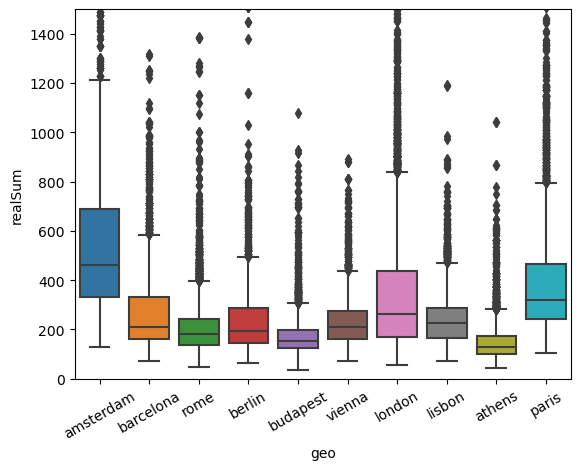

<Figure size 640x480 with 0 Axes>

In [13]:
# Plotting the graph
sns.boxplot(x='geo', y='realSum', data=df)
plt.ylim(0, 1500)
plt.xticks(rotation=30)
plt.show()
plt.clf()

We can see that pricing varies from city to city with otliers reaching 18545 euros per two nights. Let's look into the pricing more closely.

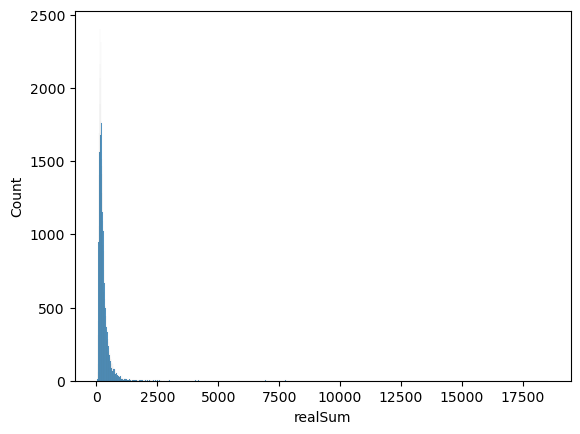

<Figure size 640x480 with 0 Axes>

In [14]:
# Plotting pricing histogram for 99% of the observations
sns.histplot(df['realSum'])
plt.show()
plt.clf()

We see on the graphs that prices have major outliers. Let's see how the graph will react if we display 99% of the observed data.

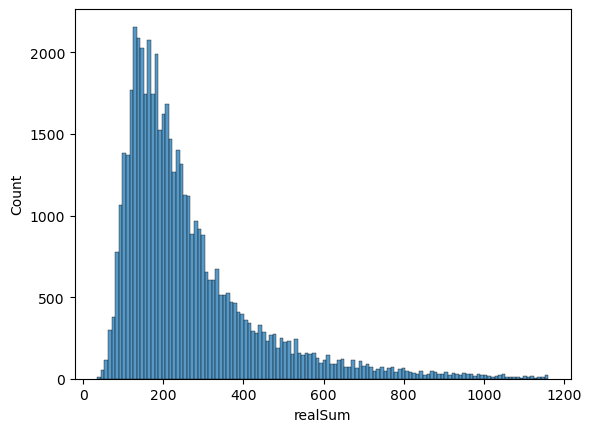

<Figure size 640x480 with 0 Axes>

In [15]:
# Plotting pricing histogram for 99% of the observations
sns.histplot(df['realSum'][df['realSum'] < df['realSum'].quantile(0.99)])
plt.show()
plt.clf()

As we can see on the graph, 99% of the price observations are under 1200 euros per two nights. Prices counts are strongly skewed to the right.

## Building a model
### Getting the data ready
Now that we had a look into the graphs, I will begin creating prediction model.
I will start with transforming categorical data and creating relation heatmap.
I will also get rid of attractive index and restaurant index variables since authors already included standardized version of these variables. Same as before, I will be working with the prices counts under 99th quantile.

In [16]:
# Dropping the outliers
df = df[df['realSum'] < df['realSum'].quantile(0.99)]

# Creating a dataset for a machine learning model and one-hot-encoding categorical data
df_model = pd.get_dummies(df, columns=['room_type', 'geo', 'week'], drop_first=True)

# Dropping not standardized data
df_model = df_model.drop(columns=['attr_index', 'rest_index'], axis=1)

In [17]:
# Checking modified dataset
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50827 entries, 0 to 51340
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     50827 non-null  float64
 1   person_capacity             50827 non-null  float64
 2   host_is_superhost           50827 non-null  bool   
 3   multi                       50827 non-null  int64  
 4   biz                         50827 non-null  int64  
 5   cleanliness_rating          50827 non-null  float64
 6   guest_satisfaction_overall  50827 non-null  float64
 7   bedrooms                    50827 non-null  int64  
 8   dist                        50827 non-null  float64
 9   metro_dist                  50827 non-null  float64
 10  attr_index_norm             50827 non-null  float64
 11  rest_index_norm             50827 non-null  float64
 12  room_type_Private room      50827 non-null  uint8  
 13  geo_athens                  508

Now, that we have created a new dataset for a model, let's look into the correlation matrix and the heatmap buit on top of it.

In [18]:
# Creating a correlation matrix
corr = df_model.corr()
display(corr)

realSum  person_capacity  host_is_superhost  \
realSum                     1.000000         0.313579          -0.075624   
person_capacity             0.313579         1.000000           0.033467   
host_is_superhost          -0.075624         0.033467           1.000000   
multi                      -0.085422        -0.054167           0.097506   
biz                         0.084860         0.106949          -0.107775   
cleanliness_rating         -0.017546         0.003804           0.273619   
guest_satisfaction_overall -0.028816         0.004589           0.281793   
bedrooms                    0.265068         0.559725           0.025503   
dist                       -0.068003        -0.127213          -0.055774   
metro_dist                 -0.094867        -0.033649          -0.001477   
attr_index_norm             0.430839        -0.069135          -0.092033   
rest_index_norm             0.251259         0.031381          -0.018953   
room_type_Private room     -0.293375        -0.501570          -0.052278   
geo_athens                 -0.226738         0.146821           0.133651   
geo_barcelona               0.016232        -0.101312          -0.041820   
geo_berlin                 -0.035238        -0.072419           0.002488   
geo_budapest               -0.152581         0.089756           0.082428   
geo_lisbon                 -0.047404         0.050531          -0.035010   
geo_london                  0.176576        -0.125682          -0.111615   
geo_paris                   0.243296        -0.069996          -0.102004   
geo_rome                   -0.161424         0.075657           0.074362   
geo_vienna                 -0.050164         0.043811           0.017380   
week_weekends               0.026077        -0.011404          -0.006085   

                               multi       biz  cleanliness_rating  \
realSum                    -0.085422  0.084860           -0.017546   
person_capacity            -0.054167  0.106949            0.003804   
host_is_superhost           0.097506 -0.107775            0.273619   
multi                       1.000000 -0.470479            0.041626   
biz                        -0.470479  1.000000           -0.108276   
cleanliness_rating          0.041626 -0.108276            1.000000   
guest_satisfaction_overall  0.054466 -0.209790            0.711711   
bedrooms                    0.000403 -0.026565            0.029724   
dist                        0.032742 -0.165520           -0.028900   
metro_dist                  0.043479 -0.108178            0.011836   
attr_index_norm            -0.039910  0.093881           -0.083322   
rest_index_norm            -0.035633  0.084984           -0.008974   
room_type_Private room      0.137088 -0.038611           -0.032861   
geo_athens                 -0.018928  0.021869            0.088356   
geo_barcelona               0.051238 -0.014596           -0.025422   
geo_berlin                 -0.004263 -0.089017            0.019435   
geo_budapest                0.007837 -0.000451            0.026129   
geo_lisbon                 -0.041387  0.176631           -0.005263   
geo_london                 -0.018621  0.038469           -0.113825   
geo_paris                  -0.061471 -0.087557           -0.053243   
geo_rome                    0.095296 -0.014125            0.060128   
geo_vienna                 -0.008465 -0.005061            0.024708   
week_weekends              -0.005246 -0.017569            0.000901   

                            guest_satisfaction_overall  bedrooms      dist  \
realSum                                      -0.028816  0.265068 -0.068003   
person_capacity                               0.004589  0.559725 -0.127213   
host_is_superhost                             0.281793  0.025503 -0.055774   
multi                                         0.054466  0.000403  0.032742   
biz                                          -0.209790 -0.026565 -0.165520   
cleanliness_rating                            0.711711 

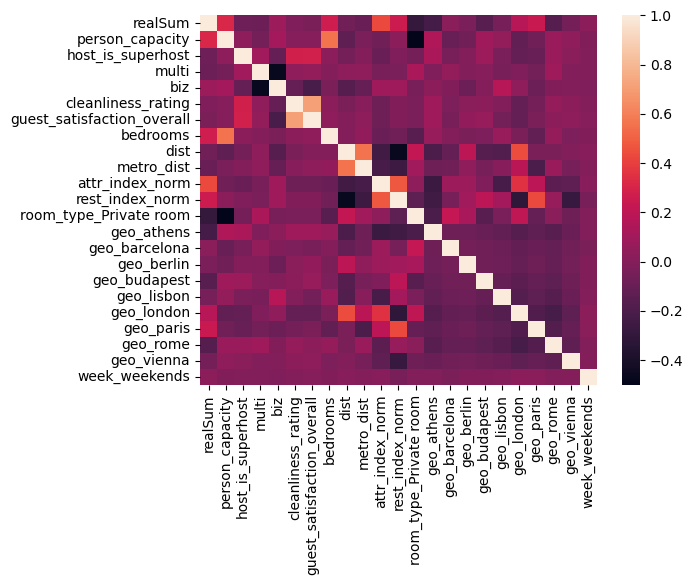

In [19]:
# Plotting a heatmap
sns.heatmap(corr)
plt.show()

On the heatmap we can see that cleanliness rating and guest satisfaction rating are correlating at a high level of 0.71. I will drop the variable with a less impact on the final price.

In [20]:
# dropping cleanliness rating
df_model = df_model.drop(columns=['cleanliness_rating'], axis=1)

### Finding a baseline
Now, that we only have the data we need for a model, we can start training it. I have chosen random forest regressor for this project since it shows good results for datasets this big.<br>
<br>
But before we build the model, there is one question to answer: "How do we know if the model performs good?".<br>
To answer this question we need a baseline for reference. If a model performs better than this baseline, it is safe to say that the model is succesful.<br>
<br>
For the baseline I have chosen average prices across the cities. In other words, baseline for evaluating the model will be mean squared error and r2 score, as if we have predicted each airbnb price to be the same as the average price for this city.

In [21]:
# Features and labels for model
features_model = df_model.drop(columns=['realSum'], axis=1)
labels_model = df_model['realSum']

# Features and labels of all the data
features = df.drop(columns=['realSum'], axis=1)
labels = df['realSum']

In [22]:
# Creating train and test split
train_features, test_features, train_labels, test_labels = train_test_split(features_model, labels_model, test_size=0.2, random_state=23)

train_features_base, test_features_base, train_labels_base, test_labels_base = train_test_split(features, labels, test_size=0.2, random_state=23)


In [23]:
# Baseline predictions by geo
baseline_preds = test_features_base['geo'].apply(lambda x: df['realSum'][df['geo'] == x].mean())
avg_baseline_errors = mean_squared_error(test_labels_base, baseline_preds)

In [24]:
# Displaying baseline
display(f'Baseline mean squared error: {avg_baseline_errors}')
display(f'Baseline r2 score: {r2_score(test_labels_base, baseline_preds)}')

'Baseline mean squared error: 20857.969025163806'

'Baseline r2 score: 0.2489019157784581'

### Training model
Now that we know our baseline we can start training a model. I will instantiate random forest regressor and measure how well it performs.

In [25]:
# Instantiating random forest regressor
regressor = RandomForestRegressor(random_state=23)

In [26]:
# Training the model
regressor.fit(train_features, train_labels)
labels_pred = regressor.predict(test_features)
display(f'Model mean squared error: {mean_squared_error(test_labels, labels_pred)}')
display(f'Model r2 score: {regressor.score(test_features, test_labels)}')

'Model mean squared error: 5543.155042160142'

'Model r2 score: 0.8003902907475544'

We see that the model performs much better than the baseline. But can we tune it to do even better?

### Tuning the model
To tune the model's hyperparameters I will use "RandomizedSearchCV" class. The problem is  this method requires a lot of computational power when used with big datasets such as ours. To solve this problem I will sample the data. This way this method will still take a lot of time but at least it will be doable.

In [27]:
# Random sampling
sample = df_model.sample(12000, random_state=23)

In [28]:
# Making sets of features and labels
sample_features = sample.drop(columns=['realSum'], axis=1)
sample_labels = sample['realSum']

In [29]:
# Splitting the data to train and test
train_features_sample, test_features_sample, train_labels_sample, test_labels_sample = train_test_split(sample_features, sample_labels, test_size=0.2)

In [30]:
# Checking how well stanrard regressor performs on the sample
regressor.fit(train_features_sample, train_labels_sample)
labels_pred_sample = regressor.predict(test_features_sample)
display(f'Sample mean squared error: {mean_squared_error(test_labels_sample, labels_pred_sample)}')
display(f'Sample r2 score{r2_score(test_labels_sample, labels_pred_sample)}')

'Sample mean squared error: 10173.40895025'

'Sample r2 score0.6235295826306173'

We see that the model performs worse on the sample data. But if we will be able to tune the model here, then same hyperparameters should work on the main data.

In [31]:
# Instantiating a random grid with hyperparameters
n_estimators = [int(x) for x in np.linspace(200, 2000, 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 70, 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [32]:
# Instantiating the RandomizedSearchCV
rf_random = RandomizedSearchCV(regressor, 
                               param_distributions=random_grid, 
                               n_iter=100, 
                               cv=5, 
                               random_state=23, 
                               n_jobs=-1
                              )

In the code above I used "verbose=3" in case my computer won't be able to make the computations.

In [33]:
# Fitting the data
rf_random.fit(train_features_sample, train_labels_sample)

/Users/klimgruzdev/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=23),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 25, 40, 55, 70, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 650, 1100, 1550,
                                                         2000]},
                   random_state=23)

Now let's look at the best estimators and it's score:

In [34]:
# Displaying the results
display(rf_random.best_estimator_)
display(rf_random.best_score_)

RandomForestRegressor(bootstrap=False, max_depth=25, max_features='sqrt',
                      n_estimators=1100, random_state=23)

0.6924685479608543

***
The model performs better with these hyperparameters. Let's see if the model will do the same with the whole dataset.

In [35]:
# Instantiating new model
regressor_tweaked = RandomForestRegressor(
    bootstrap=False, 
    max_depth=70, 
    max_features='sqrt', 
    n_estimators=650, 
    random_state=23
)

In [36]:
# Fitting the new model
regressor_tweaked.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=False, max_depth=70, max_features='sqrt',
                      n_estimators=650, random_state=23)

In [37]:
# Printing score
tweaked_score = regressor_tweaked.score(test_features, test_labels)
print(f'Score: {tweaked_score}')

Score: 0.8115511243147494


In [38]:
# Printing mean squared error
labels_tweaked_pred = regressor_tweaked.predict(test_features)

display(f'Mean squared error: {mean_squared_error(test_labels, labels_tweaked_pred)}')

'Mean squared error: 5233.219062119888'

We see that the model itself also improved it's score by more than 1%. It is possible to increase this number even more by using GridSearchCV to tune the model.

## Inspecting feature importance
Now let's look into the decision trees of our random forest, so the model would be less of a black box it is now.

In [39]:
# Printing feature importances
feature_importances = list(zip(regressor_tweaked.feature_names_in_, regressor_tweaked.feature_importances_))
display('Feature importances:')
display(feature_importances)

'Feature importances:'

[('person_capacity', 0.07515713529143728),
 ('host_is_superhost', 0.008391976645237631),
 ('multi', 0.008632126517995251),
 ('biz', 0.01349921632634647),
 ('guest_satisfaction_overall', 0.048009137921399846),
 ('bedrooms', 0.09013682883712103),
 ('dist', 0.08895192739181759),
 ('metro_dist', 0.07237361196177233),
 ('attr_index_norm', 0.20689605277565332),
 ('rest_index_norm', 0.09966573501062367),
 ('room_type_Private room', 0.06838657821660883),
 ('geo_athens', 0.03893545523013995),
 ('geo_barcelona', 0.009962131224514247),
 ('geo_berlin', 0.008876957108183564),
 ('geo_budapest', 0.03843986063637368),
 ('geo_lisbon', 0.013186908984639189),
 ('geo_london', 0.03706174453695912),
 ('geo_paris', 0.03130574276648652),
 ('geo_rome', 0.0294134317251337),
 ('geo_vienna', 0.006946824177501454),
 ('week_weekends', 0.005770616714055382)]

## Overview
The project aimed to predict Airbnb prices in Europe using machine learning algorithm. The random forest regressor model performed well having <b>mean squared score of 5233</b> and <b>R2 score of 0.81</b>. However, there is still room for improvement. Techniques like GridSearchCV can be used to fine-tune the model's hyperparameters. Additionally, incorporating other relevant features and exploring alternative algorithms and ensemble methods could further enhance the accuracy of predictions. Overall, the project provides valuable insights for Airbnb hosts and travelers in the European market, with potential for further refinement and optimization.